In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tools_cv import *

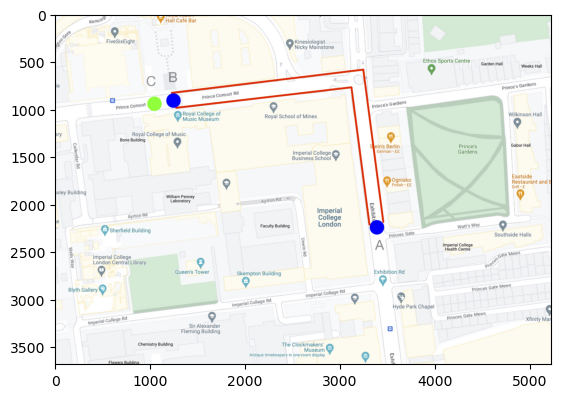

In [19]:
%matplotlib inline
img = cv2.imread('CWMap.jpg')  # BGR
show_img(img)

In [20]:
img_R = extract_color(img, 'R')
img_G = extract_color(img, 'G')
img_B = extract_color(img, 'B')

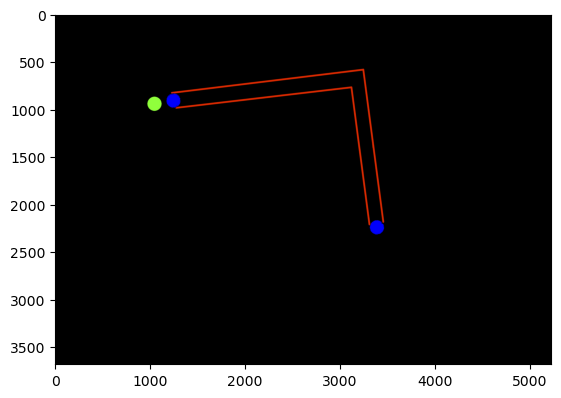

In [21]:
# show_img(img_R)
# show_img(img_G)
# show_img(img_B)
show_img(img_R + img_G + img_B)

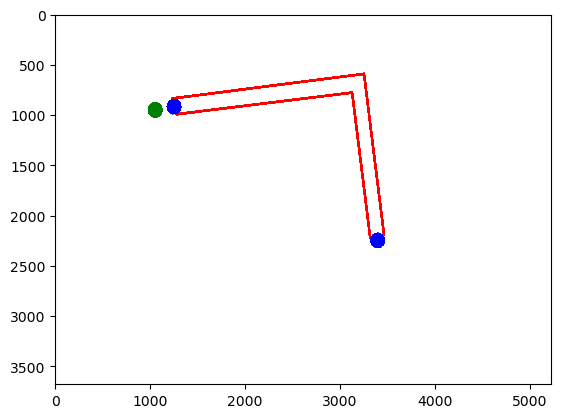

In [22]:
R_coords = mask2xy(img_R)
G_coords = mask2xy(img_G)
B_coords = mask2xy(img_B)

plt.scatter(R_coords[:, 0], R_coords[:, 1], c='r', s=0.1, linewidth=0.1)
plt.scatter(G_coords[:, 0], G_coords[:, 1], c='g', s=0.1, linewidth=0.1)
plt.scatter(B_coords[:, 0], B_coords[:, 1], c='b', s=0.1, linewidth=0.1)
plt.xlim([0, img.shape[1]])
plt.ylim([img.shape[0], 0])
plt.show()

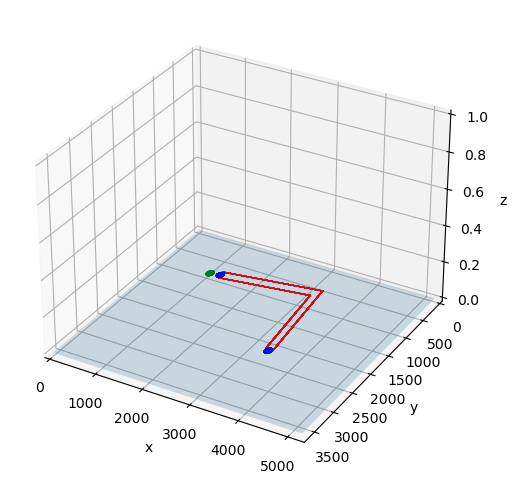

In [25]:

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([0, img.shape[1]])
ax.set_ylim([img.shape[0], 0])
ax.set_zlim([0, 1])

ax.scatter(R_coords[:, 0], R_coords[:, 1], 0, c='r', s=0.1, linewidth=0.1)
ax.scatter(G_coords[:, 0], G_coords[:, 1], 0, c='g', s=0.1, linewidth=0.1)
ax.scatter(B_coords[:, 0], B_coords[:, 1], 0, c='b', s=0.1, linewidth=0.1)


x, y = np.meshgrid(np.linspace(0, img.shape[1], 1000), np.linspace(0, img.shape[0], 1000))
z = np.zeros_like(x)
ax.plot_surface(x, y, z, alpha=0.2)

my_car = CarLines3D()
lines = my_car.get_lines()

plt.show()

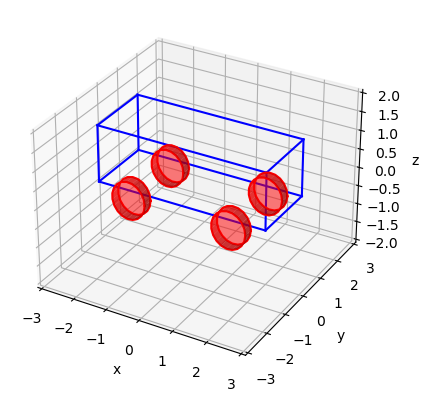

In [165]:
class Car:
    def __init__(self, length, width, height, wheel_radius, wheel_width, wheel_offset, wheel_base=None):
        self.length = length
        self.width = width
        self.height = height
        self.wheel_radius = wheel_radius
        self.wheel_width = wheel_width
        self.wheel_offset = wheel_offset
        if wheel_base is None:
            self.wheel_base = self.length -2*self.wheel_radius
        else:
            self.wheel_base = wheel_base
    
    def plot_body(self, ax):
        # corner points of the cuboid
        top_front_left = np.array([self.length / 2, self.width / 2, 0])
        top_front_right = np.array([self.length / 2, -self.width / 2, 0])
        top_rear_left = np.array([-self.length / 2, self.width / 2, 0])
        top_rear_right = np.array([-self.length / 2, -self.width / 2, 0])
        bot_front_left = np.array([self.length / 2, self.width / 2, self.height])
        bot_front_right = np.array([self.length / 2, -self.width / 2, self.height])
        bot_rear_left = np.array([-self.length / 2, self.width / 2, self.height])
        bot_rear_right = np.array([-self.length / 2, -self.width / 2, self.height])
        
        # line segments for the car body
        body_lines = [
            np.array([top_front_left, top_front_right]),
            np.array([top_front_right, top_rear_right]),
            np.array([top_rear_right, top_rear_left]),
            np.array([top_rear_left, top_front_left]),
            np.array([bot_front_left, bot_front_right]),
            np.array([bot_front_right, bot_rear_right]),
            np.array([bot_rear_right, bot_rear_left]),
            np.array([bot_rear_left, bot_front_left]),
            np.array([top_front_left, bot_front_left]),
            np.array([top_front_right, bot_front_right]),
            np.array([top_rear_right, bot_rear_right]),
            np.array([top_rear_left, bot_rear_left])
        ]
        for line in body_lines:
            ax.plot(line[:,0], line[:,1], line[:,2], 'b')
            
    def plot_wheels(self, ax):
        # center points of the wheels
        front_left_wheel = np.array([self.length / 2, self.width / 2, 0])
        front_right_wheel = np.array([self.length / 2, -self.width / 2, 0])
        rear_left_wheel = np.array([-self.length / 2, self.width / 2, 0])
        rear_right_wheel = np.array([-self.length / 2, -self.width / 2, 0])
        
        x_shift = np.array([(self.length-self.wheel_base)/2, 0, 0])
        y_shift = np.array([0, self.wheel_width/2, 0])
        z_shift = np.array([0, 0, -self.wheel_offset])
        
        self.plot_wheel(ax, front_left_wheel - x_shift + z_shift, y_shift)
        self.plot_wheel(ax, front_right_wheel - x_shift + z_shift, y_shift)
        self.plot_wheel(ax, rear_left_wheel + x_shift + z_shift, y_shift)
        self.plot_wheel(ax, rear_right_wheel + x_shift + z_shift, y_shift)
    
    def plot_wheel(self, ax, center, y_shift, num_points=20): 
        r = self.wheel_radius
        w = self.wheel_width
        
        center1 = center + y_shift
        center2 = center - y_shift
        
        # Generate points on a circle
        t = np.linspace(0, 2 * np.pi, num_points)
        x1 = center1[0] + r * np.cos(t)
        y1 = center1[1] * np.ones_like(t)
        z1 = center1[2] + r * np.sin(t)
        x2 = center2[0] + r * np.cos(t)
        y2 = center2[1] * np.ones_like(t)
        z2 = center2[2] + r * np.sin(t)
        
        ax.plot(x1, y1, z1, 'r')
        ax.plot(x2, y2, z2, 'r')

        # fill cylinder circular surface
        ax.plot_surface(np.vstack([x1, x2]), np.vstack([y1, y2]), np.vstack([z1, z2]), color='r', alpha=0.7)
        # fill cylinder circular bases
        circle1 = plt.Circle((center1[0], center1[2]), r, color='r', alpha=0.3)
        circle2 = plt.Circle((center2[0], center2[2]), r, color='r', alpha=0.3)
        ax.add_patch(circle1)
        ax.add_patch(circle2)
        art3d.pathpatch_2d_to_3d(circle1, z=center1[1], zdir="y")
        art3d.pathpatch_2d_to_3d(circle2, z=center2[1], zdir="y")
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

car = Car(length=5, width=2, height=1.5, wheel_radius=0.5, wheel_width=0.3, wheel_offset=0.2, wheel_base=3)
car.plot_body(ax)
car.plot_wheels(ax)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([-2, 2])

plt.show()